#### Predict total sales for every product and shop in the next month

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

from xgboost import XGBRegressor
from xgboost import plot_importance

#from googletrans import Translator

In [3]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',50)

In [98]:
#% is in line magic command in jupyter
%ls 
%pwd

 Volume in drive C is Windows

'C:\\Users\\ankita\\Documents\\Coursework\\DataAnalytics-R\\competitive-data-science-predict-future-sales'


 Volume Serial Number is B841-BE94

 Directory of C:\Users\ankita\Documents\Coursework\DataAnalytics-R\competitive-data-science-predict-future-sales

11/26/2020  04:18 PM    <DIR>          .
11/26/2020  04:18 PM    <DIR>          ..
11/24/2020  09:01 PM    <DIR>          .ipynb_checkpoints
11/24/2020  07:28 PM             3,573 item_categories.csv
11/24/2020  07:28 PM         1,568,417 items.csv
11/26/2020  04:18 PM            63,004 predict-future-sales.ipynb
11/24/2020  07:28 PM        94,603,866 sales_train.csv
11/24/2020  07:28 PM         2,245,108 sample_submission.csv
11/24/2020  07:28 PM             2,977 shops.csv
11/24/2020  07:28 PM         3,182,735 test.csv
               7 File(s)    101,669,680 bytes
               3 Dir(s)  389,462,016,000 bytes free


In [23]:
train = pd.read_csv("./sales_train.csv")
test = pd.read_csv("./test.csv")
shops = pd.read_csv("./shops.csv")
items = pd.read_csv("./items.csv")
item_categories = pd.read_csv("./item_categories.csv")

#items = pd.read_csv("./items.csv", usecols = ['item_id','item_category_id'])

#joining the train data with items to get item category in train
train = pd.merge(train,items[['item_id','item_category_id']],how = 'inner', on = ['item_id'])
test = pd.merge(test,items[['item_id','item_category_id']], on = ['item_id'], how = 'left')

#checking if any value in the join is null
test.isnull().values.any()

train.head()
#test.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,20.01.2013,0,27,22154,999.0,1.0,37
3,02.01.2013,0,25,22154,999.0,1.0,37
4,03.01.2013,0,25,22154,999.0,1.0,37


### data preprocessing

In [4]:
#number of rows
len(train)

2935849

**Checking the validity of entries in all columns**

In [4]:
#checking valid minimum and maximum values of all columns

minmax = pd.DataFrame(np.min(train))
minmax.columns = ['minimum']
minmax['maximum'] = np.max(train)
minmax

,minimum,maximum
date,01.01.2013,31.12.2014
date_block_num,0,33
shop_id,0,59
item_id,0,22169
item_price,-1,307980
item_cnt_day,-22,2169
item_category_id,0,83


In [5]:
print(minmax.loc['date_block_num','minimum'] < 0 or minmax.loc['date_block_num','maximum'] > 33)

print(minmax.loc['shop_id','minimum'] < min(shops.shop_id) or minmax.loc['shop_id','maximum'] > max(shops.shop_id))

print(minmax.loc['item_id','minimum'] < min(items.item_id) or minmax.loc['item_id','maximum'] > max(items.item_id))

print(minmax.loc['item_category_id','minimum'] < min(item_categories.item_category_id) or minmax.loc['item_category_id','maximum'] > max(item_categories.item_category_id))

#date_block_num, shop_id, item_id and item_category_id have valid values 

False
False
False
False


**inspecting item_price = -1 and substituting it with price for that item from the date range in which the item purchase date falls**

In [24]:
error_item_id = train.loc[train['item_price'] == -1,["item_id","date_block_num","shop_id","date"]]

train[(train['item_id'] == error_item_id['item_id'][56049]) & 
      (train['date_block_num'] == error_item_id['date_block_num'][56049])&
     (train['item_price'] == 1249)].head()

#since the date of the item_price with value -1 is 15.05.2013 which lies in the range of dates of item_price 1249, 
#therefore we will chnage the price to 1249
train.loc[train['item_price'] == -1,["item_price"]] = 1249

**Checking shop ids and relabelling duplicate shops**

In [25]:
#shopid[0] and shopid[57] seem to be the same
train.loc[train.shop_id == 0,'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

#shopid[1] and shopid[58] seem to be the same
train.loc[train.shop_id == 1,'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

#shopid[10] and shopid[11]
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10,'shop_id'] = 11

**Inspecting the variable 'item_cnt_day' and 'price'** 

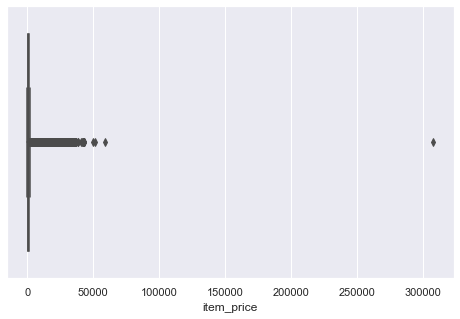

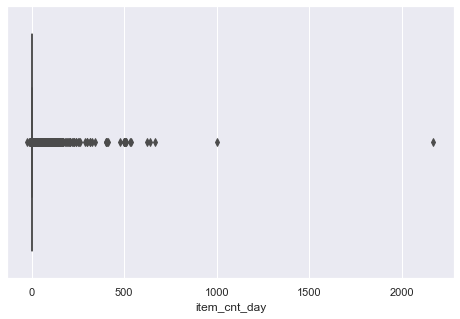

In [8]:
plt.figure(figsize = (8,5))
ax = sns.boxplot(data = train, x = 'item_price')

plt.figure(figsize = (8,5))
ax = sns.boxplot(data = train, x = 'item_cnt_day')

**removing values in item_cnt_day > 1000 and item_price > 100000**

In [26]:
train = train[train.item_cnt_day <= 1000]
train = train[train.item_price <= 1000000]

**inspecting negative 'item_cnt_day'**  
If negative item_cnt_day are returned products we should be able to account for most of them with a previous 'buy' of these items

In [10]:
train_grouped = train.groupby(by = ['shop_id','item_id']).sum()
train_grouped[train_grouped['item_cnt_day'] < 0].head()
#number of rows with unaccounted negative item_cnt_day are 24

date_block_num  item_price  item_cnt_day  item_category_id
shop_id item_id                                                            
4       12211                 0      1399.0          -1.0                62
12      1590                 10     18193.0         -12.0               203
        1592                  0      3999.0          -1.0                23
        1593                  1      7196.0          -7.0               116
        8200                  0       149.0          -1.0                40

Out of 7000 values which have negative item_cnt_day only 27 rows still have negative item_cnt_day most of which have date_block_num '0', therefore these products might be returned items and cannot be treated as invalid entries

### Feature Engineering

In [11]:
#tabulating monthly items sold for each item
train_monthly = pd.DataFrame(train[['shop_id','date_block_num','item_id','item_cnt_day']].groupby(by = ['shop_id','date_block_num','item_id']).sum())
train_monthly.reset_index(inplace =  True)
train_monthly.rename(columns = {'item_cnt_day':'item_cnt_mnt'}, inplace = True)

#tabulating average monthly items sold for each item
avg_itm_cnt_mnth = pd.DataFrame(train[['shop_id','date_block_num','item_id','item_cnt_day']].groupby(by = ['shop_id','date_block_num','item_id']).mean())
avg_itm_cnt_mnth.reset_index(inplace = True)
avg_itm_cnt_mnth.rename(columns = {'item_cnt_day':'avg_item_count_mnt'}, inplace = True)
train_monthly = pd.merge(train_monthly,avg_itm_cnt_mnth, how = 'left', on = ['shop_id','date_block_num','item_id'])

#joining train_monthly with item_category_id
train_monthly = pd.merge(train_monthly, items[['item_id','item_category_id']], on = 'item_id', how = 'left')


train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id
0,2,0,27,1.0,1.0,19
1,2,0,33,1.0,1.0,37
2,2,0,317,1.0,1.0,45
3,2,0,438,1.0,1.0,45
4,2,0,471,2.0,1.0,49


In [12]:
#merging train_monthly and test for feature engineering 

test.drop(columns = ['ID'], inplace = True)
test['date_block_num'] = 34
train_monthly = train_monthly.append(test, sort = False, ignore_index = True)

train_monthly.tail()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id
1823319,45,34,18454,NaN,NaN,55
1823320,45,34,16188,NaN,NaN,64
1823321,45,34,15757,NaN,NaN,55
1823322,45,34,19648,NaN,NaN,40
1823323,45,34,969,NaN,NaN,37


In [13]:
#adding the month variable to data, since sales might be high for certain months and low for others 
train_monthly['month'] = train_monthly['date_block_num'] % 12
train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month
0,2,0,27,1.0,1.0,19,0
1,2,0,33,1.0,1.0,37,0
2,2,0,317,1.0,1.0,45,0
3,2,0,438,1.0,1.0,45,0
4,2,0,471,2.0,1.0,49,0


**Lag features to account for seasonal components in data** 

In [14]:
def lag_features(df,feature):
    
    lags = [1,2,3,4,6,12]
    tmp = df[['shop_id','date_block_num','item_id',feature]]
    
    for i in lags:
        cp = tmp.copy()
        cp['date_block_num'] += i
        cp.rename(columns = {feature:feature+'_lag_'+str(i)}, inplace = True)
        df = pd.merge(df,cp, how = 'left', on = ['shop_id','date_block_num','item_id'])
    
    return(df)

train_monthly = lag_features(train_monthly,'item_cnt_mnt')
train_monthly = lag_features(train_monthly, 'avg_item_count_mnt')

train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**mean features**

In [15]:
#taking mean sales of items for each shop
mean_item = pd.DataFrame(train_monthly.groupby(by = ['shop_id','item_id']).mean()['item_cnt_mnt'])
mean_item.reset_index(inplace = True)
mean_item.rename(columns = {'item_cnt_mnt':'avg_item_cnt_shp'}, inplace = True)

train_monthly = pd.merge(train_monthly,mean_item, on = ['shop_id','item_id'], how = 'left')

del mean_item
train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [16]:
#taking mean sales of items for each month
#grouping by month and not date_block_num since we might see similar sales patterns for months each year

mean_items_mnth = pd.DataFrame(train_monthly.groupby(by = ['item_id','month']).mean()['item_cnt_mnt'])
mean_items_mnth.reset_index(inplace = True)
mean_items_mnth.rename(columns = {'item_cnt_mnt':'glb_avg_itm_cnt_mnt'}, inplace = True)

train_monthly = pd.merge(train_monthly,mean_items_mnth, on = ['item_id','month'], how = 'left')

del mean_items_mnth
train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp,glb_avg_itm_cnt_mnt
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.876923
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.214286


In [17]:
#taking mean sales of each shop by month

mean_shp_mnth = pd.DataFrame(train_monthly.groupby(by = ['month','shop_id']).mean()['item_cnt_mnt'])
mean_shp_mnth.reset_index(inplace = True)
mean_shp_mnth.rename(columns = {'item_cnt_mnt':'glb_avg_shop_sales'}, inplace = True)

train_monthly = pd.merge(train_monthly,mean_shp_mnth, on = ['month','shop_id'], how = 'left')

del mean_shp_mnth
train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp,glb_avg_itm_cnt_mnt,glb_avg_shop_sales
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.876923,1.785588
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.214286,1.785588


In [18]:
#taking mean sales of each shop by date_block_num
mean_shp_blck_num = pd.DataFrame(train_monthly.groupby(by = ['date_block_num','shop_id']).mean()['item_cnt_mnt'])
mean_shp_blck_num.reset_index(inplace = True)
mean_shp_blck_num.rename(columns = {'item_cnt_mnt':'date_block_avg_shop_sales'}, inplace = True)

train_monthly = pd.merge(train_monthly,mean_shp_blck_num, on = ['date_block_num','shop_id'], how = 'left')

del mean_shp_blck_num

train_monthly = lag_features(train_monthly, 'date_block_avg_shop_sales')
train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp,glb_avg_itm_cnt_mnt,glb_avg_shop_sales,date_block_avg_shop_sales,date_block_avg_shop_sales_lag_1,date_block_avg_shop_sales_lag_2,date_block_avg_shop_sales_lag_3,date_block_avg_shop_sales_lag_4,date_block_avg_shop_sales_lag_6,date_block_avg_shop_sales_lag_12
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.876923,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.214286,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#taking mean sales by item_category, shop_id and date_block_num

mean_itm_cat = pd.DataFrame(train_monthly.groupby(by = ['shop_id','item_category_id','date_block_num']).mean()['item_cnt_mnt'])
mean_itm_cat.reset_index(inplace = True)
mean_itm_cat.rename(columns = {'item_cnt_mnt':'cat_cnt_mnt'}, inplace = True)

train_monthly = pd.merge(train_monthly, mean_itm_cat, on = ['shop_id','item_category_id','date_block_num'], how = 'left')

del mean_itm_cat

#creating lag features based on 'cat_cnt_mnt'

train_monthly = lag_features(train_monthly, 'cat_cnt_mnt')
train_monthly.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp,glb_avg_itm_cnt_mnt,glb_avg_shop_sales,date_block_avg_shop_sales,date_block_avg_shop_sales_lag_1,date_block_avg_shop_sales_lag_2,date_block_avg_shop_sales_lag_3,date_block_avg_shop_sales_lag_4,date_block_avg_shop_sales_lag_6,date_block_avg_shop_sales_lag_12,cat_cnt_mnt,cat_cnt_mnt_lag_1,cat_cnt_mnt_lag_2,cat_cnt_mnt_lag_3,cat_cnt_mnt_lag_4,cat_cnt_mnt_lag_6,cat_cnt_mnt_lag_12
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.900000,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.876923,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.040000,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.214286,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.142857,NaN,NaN,NaN,NaN,NaN,NaN


**adding item price based features**

In [20]:
def lag_features_mod(df,feature,lags,df_features):
    
    #tmp = df[['shop_id','date_block_num','item_id',feature]]
    tmp = df[df_features]
    
    for i in lags:
        cp = tmp.copy()
        cp['date_block_num'] += i
        cp.rename(columns = {feature:feature+'_lag_'+str(i)}, inplace = True)
        df = pd.merge(df,cp, how = 'left', on = df_features[:-1])
    
    return(df)

In [21]:
train_test = train.append(test)

avg_item_price = pd.DataFrame(train_test.groupby(by = ['item_id']).mean()['item_price'])
avg_item_price.rename(columns = {'item_price':'avg_item_price'}, inplace = True)


avg_item_price_block = pd.DataFrame(train_test.groupby(by = ['date_block_num','item_id']).mean()['item_price'])
avg_item_price_block.reset_index(inplace = True)
avg_item_price_block.rename(columns = {'item_price':'item_price_block_num'}, inplace = True)

change_price = pd.merge(avg_item_price_block ,avg_item_price ,on = ['item_id'],how = 'left')
#lagged[lagged.isna() == True] = 0

change_price['trend'] = (change_price.item_price_block_num - change_price.avg_item_price)/change_price.item_price_block_num

change_price = lag_features_mod(change_price,'trend',[1,2,3,4,6,12],['date_block_num','item_id','trend'])

train_monthly = pd.merge(train_monthly, change_price, on = ['date_block_num','item_id'], how = 'left')

del avg_item_price
del avg_item_price_block
#del change_price

def select(row):
    lags = [1,2,3,4,6,12]
    for i in lags:
        if row['trend_lag_'+str(i)]:
            return(row['trend_lag_'+str(i)])
        #else:
            #return(0)

train_monthly['lagged_trend'] = train_monthly.apply(select,axis = 1)

train_monthly.drop(columns = ['trend_lag_1','trend_lag_2','trend_lag_3','trend_lag_4','trend_lag_6', 'trend_lag_12'], inplace = True)
train_monthly.head()
    
#change_price.tail()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp,glb_avg_itm_cnt_mnt,glb_avg_shop_sales,date_block_avg_shop_sales,date_block_avg_shop_sales_lag_1,date_block_avg_shop_sales_lag_2,date_block_avg_shop_sales_lag_3,date_block_avg_shop_sales_lag_4,date_block_avg_shop_sales_lag_6,date_block_avg_shop_sales_lag_12,cat_cnt_mnt,cat_cnt_mnt_lag_1,cat_cnt_mnt_lag_2,cat_cnt_mnt_lag_3,cat_cnt_mnt_lag_4,cat_cnt_mnt_lag_6,cat_cnt_mnt_lag_12,item_price_block_num,avg_item_price,trend,lagged_trend
0,2,0,27,1.0,1.0,19,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.900000,NaN,NaN,NaN,NaN,NaN,NaN,2325.000000,1461.228571,0.371515,NaN
1,2,0,33,1.0,1.0,37,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.876923,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.040000,NaN,NaN,NaN,NaN,NaN,NaN,488.517241,252.831928,0.482450,NaN
2,2,0,317,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,299.000000,290.941176,0.026953,NaN
3,2,0,438,1.0,1.0,45,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,271.600000,290.696970,-0.070313,NaN
4,2,0,471,2.0,1.0,49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.214286,1.785588,1.574176,NaN,NaN,NaN,NaN,NaN,NaN,1.142857,NaN,NaN,NaN,NaN,NaN,NaN,399.000000,397.067416,0.004844,NaN


**handling NaN values in engineered features by substituting zero**

In [22]:
#isna() and isnull() in pandas do the same thing, to detect NaN values we can use either of the two 
#in numpy isnan() is used to detect nan values

train_monthly[train_monthly.isna() == True] = 0
train_monthly.isna().any()
#train_monthly.isna()

shop_id                             False
date_block_num                      False
item_id                             False
item_cnt_mnt                        False
avg_item_count_mnt                  False
item_category_id                    False
month                               False
item_cnt_mnt_lag_1                  False
item_cnt_mnt_lag_2                  False
item_cnt_mnt_lag_3                  False
item_cnt_mnt_lag_4                  False
item_cnt_mnt_lag_6                  False
item_cnt_mnt_lag_12                 False
avg_item_count_mnt_lag_1            False
avg_item_count_mnt_lag_2            False
avg_item_count_mnt_lag_3            False
avg_item_count_mnt_lag_4            False
avg_item_count_mnt_lag_6            False
avg_item_count_mnt_lag_12           False
avg_item_cnt_shp                    False
glb_avg_itm_cnt_mnt                 False
glb_avg_shop_sales                  False
date_block_avg_shop_sales           False
date_block_avg_shop_sales_lag_1   

In [23]:
train_monthly.to_csv(r'.//data.csv',index = False)

In [14]:
data_read = pd.read_csv("data.csv")
data_read.head()

,shop_id,date_block_num,item_id,item_cnt_mnt,avg_item_count_mnt,item_category_id,month,item_cnt_mnt_lag_1,item_cnt_mnt_lag_2,item_cnt_mnt_lag_3,item_cnt_mnt_lag_4,item_cnt_mnt_lag_6,item_cnt_mnt_lag_12,avg_item_count_mnt_lag_1,avg_item_count_mnt_lag_2,avg_item_count_mnt_lag_3,avg_item_count_mnt_lag_4,avg_item_count_mnt_lag_6,avg_item_count_mnt_lag_12,avg_item_cnt_shp,glb_avg_itm_cnt_mnt,glb_avg_shop_sales,cat_cnt_mnt,cat_cnt_mnt_lag_1,cat_cnt_mnt_lag_2,cat_cnt_mnt_lag_3,cat_cnt_mnt_lag_4,cat_cnt_mnt_lag_6,cat_cnt_mnt_lag_12,date_block_avg_shop_sales,date_block_avg_shop_sales_lag_1,date_block_avg_shop_sales_lag_2,date_block_avg_shop_sales_lag_3,date_block_avg_shop_sales_lag_4,date_block_avg_shop_sales_lag_6,date_block_avg_shop_sales_lag_12,lagged_trend
0,2,0,27,1.0,1.0,19,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.785588,1.900000,0.0,0.0,0.0,0.0,0.0,0.0,1.574176,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,33,1.0,1.0,37,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,1.876923,1.785588,1.040000,0.0,0.0,0.0,0.0,0.0,0.0,1.574176,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,317,1.0,1.0,45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.785588,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.574176,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,438,1.0,1.0,45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.785588,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.574176,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,471,2.0,1.0,49,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.214286,1.785588,1.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.574176,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Train, Test, Validation split**

In [43]:
#all months < 33 will be taken train set
X_train = data[data.date_block_num < 33].drop(columns = ['item_cnt_mnt'])
y_train = data.loc[data.date_block_num < 33, 'item_cnt_mnt']

#month = 33 will be taken validation set
X_val = data[data.date_block_num == 33].drop(columns = ['item_cnt_mnt'])
y_val = data.loc[data.date_block_num == 33, 'item_cnt_mnt']

#month = 34 is the test set
X_test = data[data.date_block_num == 34].drop(columns = ['item_cnt_mnt'])

**Fit Model** 

In [42]:
data = data_read[['shop_id','date_block_num' ,'item_id',
'item_cnt_mnt',                        
'avg_item_count_mnt',                 
'item_category_id',                    
'month',                               
'item_cnt_mnt_lag_1',          
'item_cnt_mnt_lag_2',  
'item_cnt_mnt_lag_3',      
'item_cnt_mnt_lag_4',                 
'item_cnt_mnt_lag_6',              
'item_cnt_mnt_lag_12',     
'avg_item_count_mnt_lag_1',
'avg_item_count_mnt_lag_2',            
'avg_item_count_mnt_lag_3',            
'avg_item_count_mnt_lag_4',    
'avg_item_count_mnt_lag_6',          
'avg_item_count_mnt_lag_12',          
'avg_item_cnt_shp',                  
'glb_avg_itm_cnt_mnt',                
'glb_avg_shop_sales',                  
'cat_cnt_mnt',                         
'cat_cnt_mnt_lag_1',                  
'cat_cnt_mnt_lag_2',                   
'cat_cnt_mnt_lag_3',                   
'cat_cnt_mnt_lag_4',                   
'cat_cnt_mnt_lag_6',                   
'cat_cnt_mnt_lag_12',                  
'date_block_avg_shop_sales',           
'date_block_avg_shop_sales_lag_1',     
'date_block_avg_shop_sales_lag_2',
'date_block_avg_shop_sales_lag_3',     
'date_block_avg_shop_sales_lag_4',
'date_block_avg_shop_sales_lag_6',
'date_block_avg_shop_sales_lag_12',
'lagged_trend'
]]

In [47]:
#all months < 33 will be taken train set
X_train = data[data.date_block_num < 33].drop(columns = ['item_cnt_mnt'])
y_train = data.loc[data.date_block_num < 33, 'item_cnt_mnt']
y_train.clip(0,20)

#month = 33 will be taken validation set
X_val = data[data.date_block_num == 33].drop(columns = ['item_cnt_mnt'])
y_val = data.loc[data.date_block_num == 33, 'item_cnt_mnt']
y_val.clip(0,20)

#month = 34 is the test set
X_test = data[data.date_block_num == 34].drop(columns = ['item_cnt_mnt'])

In [48]:
model = XGBRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 0.3, random_state = 100, colsample_bytree = 0.8)
model.fit(X = X_train, y = y_train, eval_metric = "rmse", eval_set = [(X_val, y_val)], verbose = True, 
          early_stopping_rounds = 20)

[0]	validation_0-rmse:5.42065
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:3.92189
[2]	validation_0-rmse:2.85829
[3]	validation_0-rmse:2.31586
[4]	validation_0-rmse:2.06416
[5]	validation_0-rmse:1.94287
[6]	validation_0-rmse:1.88278
[7]	validation_0-rmse:1.81399
[8]	validation_0-rmse:1.77583
[9]	validation_0-rmse:1.76049
[10]	validation_0-rmse:1.78437
[11]	validation_0-rmse:1.80988
[12]	validation_0-rmse:1.82415
[13]	validation_0-rmse:1.84867
[14]	validation_0-rmse:1.87202
[15]	validation_0-rmse:1.88357
[16]	validation_0-rmse:1.86378
[17]	validation_0-rmse:1.90255
[18]	validation_0-rmse:1.89792
[19]	validation_0-rmse:1.87496
[20]	validation_0-rmse:1.86881
[21]	validation_0-rmse:1.87238
[22]	validation_0-rmse:1.86440
[23]	validation_0-rmse:1.86141
[24]	validation_0-rmse:1.84766
[25]	validation_0-rmse:1.82939
[26]	validation_0-rmse:1.82780
[27]	validation_0-rmse:1.82445
[28]	validation_0-rmse:1.82826
[29]	validation_0-rmse:1.82701
Stopping. Best 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

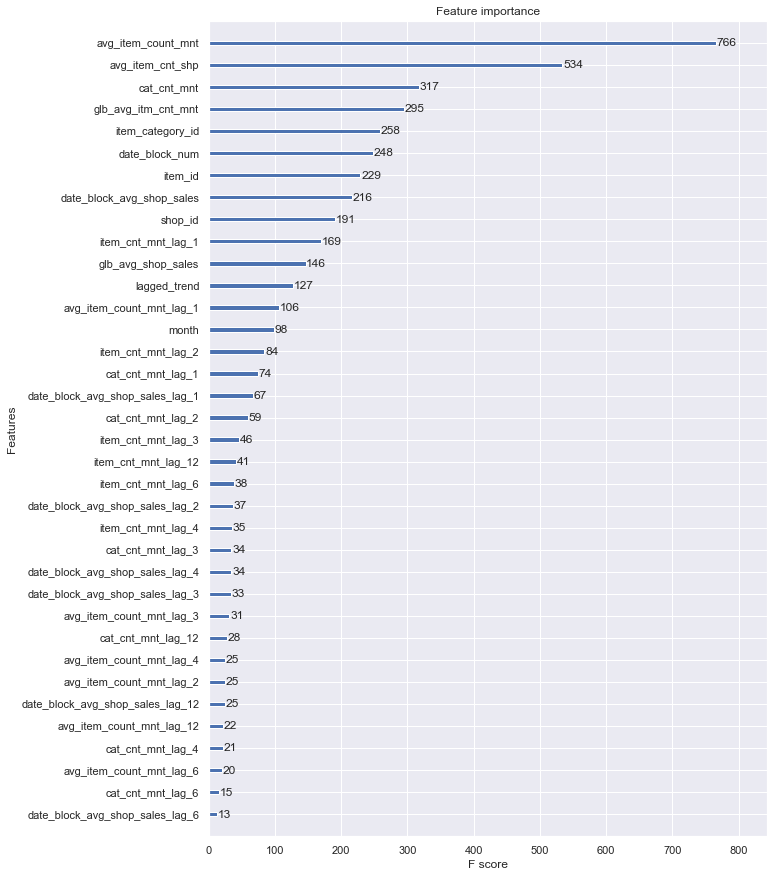

In [49]:
fig,ax = plt.subplots(1,1,figsize=(10,15))
plot_importance(model, ax = ax)

In [50]:
y_test = model.predict(X_test).clip(0,20)

submit = pd.DataFrame({'ID':test.index,'item_cnt_month':y_test})
submit.to_csv("future-sales-predictions.csv", index = False)